# Asymp app version of fig 3

Asymp

In [2]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [3]:
import pandas as pd

import seaborn as sns

from math import log, floor

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from plots2.fns import (
    get_corner_annotations,
    get_corner_annotations_custom_labels,
    get_dose_colors
)

from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
    SHAP_BLUE
)

from poly2.utils import trait_vec, gamma_dist, get_dist_mean
# from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture, get_asymptote_config
from poly2.simulator import SimulatorOneTrait, SimulatorAsymptote
from poly2.consts import FUNG_DECAY_RATE, MUTATION_PROP, MUTATION_SCALE

C:\Users\user\anaconda3\envs\poly2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [57]:
df = pd.read_csv('../outputs/combined/processed_scan_asymp.csv')
df.head()

,run,year,best_dose,asymp_mu,asymp_b,curv,dec_rate,m_prop,m_scale,nu
0,0,1,1.0,0.553325,21.458529,16.351047,1.940702,0.703574,1.95789,0.446675
1,0,2,1.0,0.553325,21.458529,16.351047,1.940702,0.703574,1.95789,0.446675
2,0,3,1.0,0.553325,21.458529,16.351047,1.940702,0.703574,1.95789,0.446675
3,0,4,1.0,0.553325,21.458529,16.351047,1.940702,0.703574,1.95789,0.446675
4,0,5,1.0,0.553325,21.458529,16.351047,1.940702,0.703574,1.95789,0.446675


In [6]:
plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize

## Bar df

In [7]:
barchartdf = (
    df
    .loc[:, ['best_dose', 'year']]
    .groupby('year')
    .value_counts()
    .reset_index()
    .rename(columns={0: 'count'})
    .pivot(index='year', columns='best_dose', values='count')
    
)

barchartdf.head(10)

best_dose,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
year,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.0
2,60.0,28.0,20.0,11.0,8.0,5.0,6.0,6.0,3.0,9853.0
3,102.0,36.0,26.0,8.0,14.0,6.0,13.0,8.0,11.0,9776.0
4,149.0,72.0,58.0,55.0,36.0,30.0,33.0,30.0,23.0,9514.0
5,232.0,140.0,115.0,70.0,72.0,50.0,60.0,50.0,46.0,9165.0
6,346.0,204.0,147.0,145.0,100.0,78.0,63.0,60.0,40.0,8817.0
7,481.0,265.0,234.0,152.0,116.0,103.0,88.0,76.0,71.0,8414.0
8,625.0,371.0,253.0,177.0,147.0,131.0,113.0,100.0,71.0,8012.0
9,802.0,428.0,295.0,220.0,189.0,126.0,117.0,90.0,99.0,7634.0


<AxesSubplot:xlabel='year'>

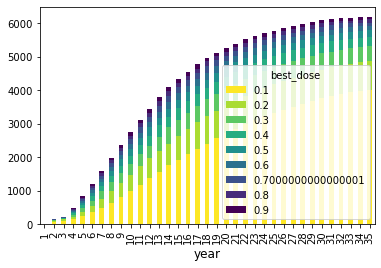

In [8]:
(
    barchartdf
    .iloc[:, :9]
    .plot
    .bar(
        stacked=True,
        colormap='viridis_r',
        legend=True
    )
)

## Line df

In [14]:
pars = (
    df
    .loc[lambda x: x.run==5]
    .head(1)
    .loc[:, [
        'asymp_mu',
        'asymp_b',
        'curv',
        'dec_rate',
        'm_prop',
        'm_scale',
        # 'ME_mean'
    ]]
)

pars

,asymp_mu,asymp_b,curv,dec_rate,m_prop,m_scale
175,0.27191,23.229268,17.057334,1.549734,0.109038,1.718981


In [58]:
pars.round(4).iloc[0].to_dict()

{'asymp_mu': 0.2719,
 'asymp_b': 23.2293,
 'curv': 17.0573,
 'dec_rate': 1.5497,
 'm_prop': 0.109,
 'm_scale': 1.719}

In [19]:
from poly2.config import get_asymptote_config
from poly2.simulator import SimulatorAsymptote

In [34]:
cf = get_asymptote_config(n_years=35, n_k=300, verbose=False)

In [35]:
cf.k_mu = pars.asymp_mu.values[0]
cf.k_b = pars.asymp_b.values[0]
cf.curvature = pars.curv.values[0]
cf.decay_rate = FUNG_DECAY_RATE * pars.dec_rate.values[0]
cf.mutation_proportion = MUTATION_PROP * pars.m_prop.values[0]
cf.mutation_scale_fung = MUTATION_SCALE * pars.m_scale.values[0]

In [36]:
cf.print_repr()

CONFIG
------
I0s = [0.00985703, 0.00985703, 0.00985703, 0.00985 ...
asymptote = None
betas = [0.00786542, 0.00786542, 0.00786542, 0.007 ...
curvature = 17.05733412657077
decay_rate = 0.013955356644293385
doses = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1 ...
fungicide_mixture = False
k_b = 23.22926834613216
k_mu = 0.2719100559835807
mutation_proportion = 1.3459431551179892e-06
mutation_scale_fung = 0.034097972945506136
n_k = 300
n_years = 35
sprays = None



In [37]:
%%time

line_df = pd.DataFrame()

for dose in tqdm(np.linspace(0.1, 1, 10)):

    cf.doses = dose*np.ones(cf.n_years)

    data = SimulatorAsymptote(cf).run_model()
    
    tmp = pd.DataFrame(
        dict(
            dose=np.repeat(dose, cf.n_years),
            yld=data['yield_vec'],
            year=np.arange(1, 1+cf.n_years),
        )
    )
    
    line_df = pd.concat([line_df, tmp])
    
line_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:34<00:00, 21.46s/it]

Wall time: 3min 34s


,dose,yld,year
0,0.1,9.214023,1
1,0.1,9.203561,2
2,0.1,9.193437,3
3,0.1,9.183637,4
4,0.1,9.174159,5
...,...,...,...
30,1.0,8.952833,31
31,1.0,8.934878,32
32,1.0,8.918554,33
33,1.0,8.903965,34


In [39]:
from poly2.utils import get_best_dose_for_cb

In [40]:
bd_use = get_best_dose_for_cb(line_df, 9.9, 0.2)

## The plot

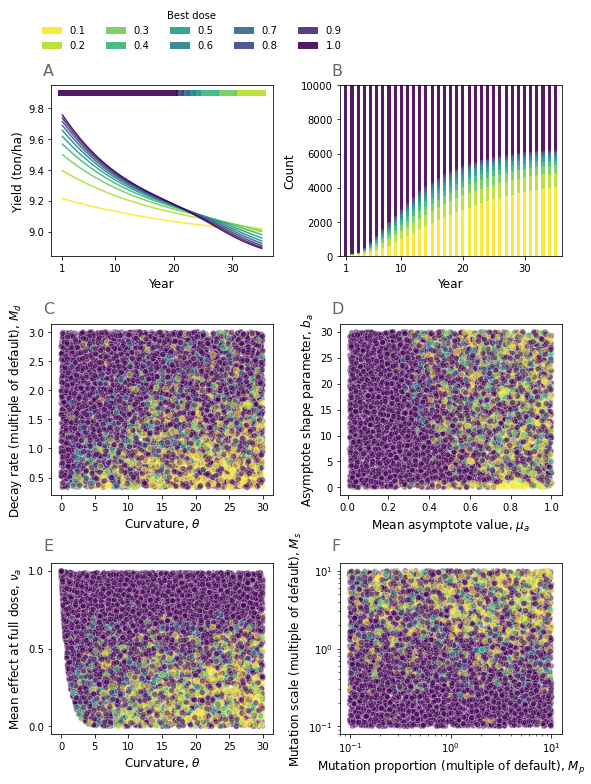

In [46]:
f, ax = plt.subplots(3, 2, figsize=(8, 12))

# A
alpha_A = 0.9

COLZ = get_dose_colors()

for ind, dose in enumerate(line_df.dose.unique()):
    n_d = len(line_df.dose.unique())
    
    colr = COLZ[ind]
    
    ax[0][0].plot(
            line_df.loc[lambda x: x.dose==dose].year,
            line_df.loc[lambda x: x.dose==dose].yld,
            alpha=alpha_A,
            c=colr)
    
    ax[0][0].plot(bd_use.loc[lambda x: x.dose==dose].year,
            bd_use.loc[lambda x: x.dose==dose].yy,
            c=colr,
            alpha=alpha_A,
            lw=6)

# B
(
    barchartdf
    .plot
    .bar(
        stacked=True,
        colormap='viridis_r',
        alpha = 0.9,
        ax=ax[0][1],
        legend=True,
    )
)


# TYPE 2

dfu = (
    df
    .loc[lambda x: x.year.isin([10])]
    .rename(columns={'dose': 'best_dose'})
)

alpha = 0.5

# C
sns.scatterplot(
    x='curv',
    y='dec_rate',
    hue='best_dose',
    data=dfu,
    alpha=alpha,
    palette='viridis_r',
    sizes=(20, 80),
    ax=ax[1][0],
    legend=False,
)

# D
sns.scatterplot(
    x='asymp_mu',
    y='asymp_b',
    hue='best_dose',
    data=dfu,
    alpha=alpha,
    palette='viridis_r',
    sizes=(20, 80),
    ax=ax[1][1],
    legend=False,
)

# E
sns.scatterplot(
    x='curv',
    y='nu',
    hue='best_dose',
    data=dfu,
    alpha=alpha,
    palette='viridis_r',
    sizes=(20, 80),
    ax=ax[2][0],
    legend=False,
)

# F
sns.scatterplot(
    x='m_prop',
    y='m_scale',
    hue='best_dose',
    data=dfu,
    alpha=alpha,
    palette='viridis_r',
    sizes=(20, 80),
    ax=ax[2][1],
    legend=False,
)

cc = 'red'
marker = 's'
ss = 80






# layout


# A
ax[0][0].set_xlabel('Year')
ax[0][0].set_ylabel('Yield (ton/ha)')
ax[0][0].set_xticks([1,10,20,30])
ax[0][0].set_xticklabels([1,10,20,30], rotation=0)


# B
ax[0][1].set_xlabel('Year')
ax[0][1].set_ylabel('Count')

ax[0][1].set_ylim([0,10000])
ax[0][1].set_xlim([-1, 35])
ax[0][1].set_xticks([0, 9, 19, 29])
ax[0][1].set_xticklabels([1,10,20,30], rotation=0)

# C
ax[1][0].set_xlabel(r'Curvature, $\theta$')
ax[1][0].set_ylabel(r'Decay rate (multiple of default), $M_d$')

# ax[1][0].set_yticks([0, 0.5, 1])

# D
ax[1][1].set_xlabel(r'Mean asymptote value, $\mu_a$')
ax[1][1].set_ylabel(r'Asymptote shape parameter, $b_a$')



# E
ax[2][0].set_xlabel(r'Curvature, $\theta$')
ax[2][0].set_ylabel(r'Mean effect at full dose, $\nu_a$')

ax[2][0].set_yticks([0, 0.5, 1])


# F
ax[2][1].set_xlabel(r'Mutation proportion (multiple of default), $M_p$')
ax[2][1].set_ylabel(r'Mutation scale (multiple of default), $M_s$')

ax[2][1].set_xscale('log')
ax[2][1].set_yscale('log')



plt.tight_layout(rect=[0,0,1,0.83], h_pad=3)

ax[0][1].legend(
    bbox_to_anchor=(0.05, 1.15),
    loc='lower right',
    labels=[f'{ii:.1f}' for ii in np.arange(0.1,1.1,0.1)],
    title='Best dose',
    ncol=5,
    framealpha=0,
)

get_corner_annotations(2, 3, 0.075, 0.82, 0.5, 0.275, plt)

In [47]:
f.savefig('../figures/paper/app6_fig1.jpg', dpi=1200, bbox_inches="tight")